In [6]:
import time
import datetime
from collections import OrderedDict
import threading
import random
import collections
import os
import numpy as np
import nidaqmx
import pickle
import sys
import pandas as pd

import quantities as pq
from nidaqmx.stream_writers import (
    DigitalSingleChannelWriter, DigitalMultiChannelWriter)
from nidaqmx.utils import flatten_channel_string
from nidaqmx.constants import (
    LineGrouping, AcquisitionType, DigitalWidthUnits, Edge,
    HandshakeStartCondition, Level, MIOAIConvertTimebaseSource,
    OverflowBehavior, TaskMode, Polarity, RegenerationMode,
    SampleInputDataWhen, SampleTimingType, UnderflowBehavior)
from nidaqmx.error_codes import DAQmxErrors, DAQmxWarnings
from nidaqmx.errors import (
    check_for_error, is_string_buffer_too_small, DaqError, DaqResourceWarning)

from scipy.optimize import fsolve, least_squares
np.set_printoptions(precision=4)

from olfactometer.valve_driver import ValveDriver
from olfactometer.equipment import Olfactometer
from olfactometer.my_equipment import  MyValve, MyJar, MyLowMFC, \
                                      MyMediumMFC, MyHighMFC
from olfactometer.odorants import Solution, Compound, ChemicalOrder, \
                                  Vendor, Molecule
# from graph import make_graph, draw_graph
from pprint import pprint
from olfactometer.smell_engine_communicator import SmellEngineCommunicator
from olfactometer.smell_engine import SmellEngine
from olfactometer.data_container import DataContainer
from olfactometer.ui import UI
from olfactometer.PID_reader import PID_Tester
from IPython.display import display

In [7]:
import numpy as np
from tqdm import tqdm
import itertools
import pandas as pd
from scipy.spatial import KDTree
import math

# Generate Concentration Space 

In [8]:
NUM_DIMENSIONS = 1 #Value of 
import sys

conc_set = [0]+np.geomspace(1e-12, 1e-6, num=49).tolist()   # Generate evenly distributed logarithmic list of concentration values ranging from [0.01, 1]

multi_dim_conc = list(itertools.product(conc_set, repeat=NUM_DIMENSIONS))    

def closest_point(conc) -> (float,int):
    rounded_points = np.ones(len(conc))
    points = np.ones(len(conc))
    for idx, axis in enumerate(conc): 
        points[idx] = axis
        rounded_points[idx]=min(conc_set, key=lambda xP:abs(xP-axis))
    dist = np.sum(np.square(points - rounded_points))
    index = multi_dim_conc.index(tuple(rounded_points))
    return dist, index


# Initialize Code To Generate Hardware States

In [9]:
NUM_VALVES = 10
NUM_BLANK_JARS = 2
NUM_ODORANT_JARS = 1 #Ethanol
NUM_MFC_SETPOINTS = 15
# Generate evenly distributed logarithmic list of concentration values ranging from [0.01, 1]
JAR_CONCENTRATIONS = np.geomspace(0.01, 1, num=7).tolist() + (np.linspace(0,1,num=10)).tolist()[0:9] #[0]+np.geomspace(0.01, 1, num=7).tolist()

# Read in valve states and number of active jars with odorants
def valve_combinations(possible_valve_states):
    combos = []
    empty_jars = [0.0 for i in range(0,(NUM_VALVES - (NUM_ODORANT_JARS+NUM_BLANK_JARS)))] # Generate list of empty jars, +1 for empty jar
    for x in possible_valve_states:    # For A states
        for y in possible_valve_states:    # For B states
            if (x == 0 or y ==0):     # ensure no valve is in both state A && B
                combos.append((float(x),float(y)))
    # Cartesian product of length number of jars with odorants +1 (for empty jar balance) => combination of all possible individual valve states within range                     
    valve_states = list(itertools.product(combos, repeat = NUM_ODORANT_JARS + NUM_BLANK_JARS))    
    return_state = []
    return_states = []
    # Convert tuple pairs (state A, state B) into list of wA[0:10] union wB[0:10]
    for state in valve_states: 
        a_s = []
        b_s = []
        for (a,b) in state:             
            #return_state = return_state + [a,b]
            a_s.append(float(a))
            b_s.append(float(b))
        return_state = a_s + empty_jars + b_s + empty_jars  # Pad occupied jars in respective state with remaining (empty) jars in respective state
        if (1 in a_s and 1 in b_s):    # Ensure there is at least 1 jar with full unit of occupancy per smell frame
            return_states.append(return_state)
        return_state = []
    return(return_states)

# Generate list of possible MFC setpoints union valve states
# param: valve_combos is the returned result of valve_combinations()
def mfc_combinations(start,end, num, valve_combos):
    total_combos = []
    if(start == 0): start = 0.01
    if(end == 0): end = 0.01
    mfc_combs = [0]+np.geomspace(start, end, num=num).tolist()   # evenly distributed logarithmic list of mfc setpoints ranging from [0.01, 1]
    # For returned valve states, append combination of MFC setpoints
    for state in valve_combos:
        for A in mfc_combs:     # For mfc A values
            for B in mfc_combs:  # for mfc B values
                if (B > 0.1): # if operating above 1 cc/min
                    total_combos.append([float(A),float(B)] + state)
    return(total_combos)

In [10]:
mfc_combs = [0]+np.geomspace(0.01, 1, num=15).tolist()
print(mfc_combs)

[0, 0.01, 0.013894954943731374, 0.019306977288832496, 0.02682695795279726, 0.0372759372031494, 0.0517947467923121, 0.07196856730011521, 0.1, 0.13894954943731375, 0.19306977288832497, 0.2682695795279725, 0.372759372031494, 0.517947467923121, 0.7196856730011517, 1.0]


# Generate Hardware States
The number of possible states to check is very large.

In [11]:
# olfactometer_combinations = valve_combinations(JAR_CONCENTRATIONS)
olfactometer_combinations = mfc_combinations(0,1,NUM_MFC_SETPOINTS,valve_combinations(JAR_CONCENTRATIONS))

print(len(olfactometer_combinations))
# print(olfactometer_combinations[10])


20160


# Import Olfactometer Dependencies 

# Initialize Molecules and Smell Engine

In [12]:
# Initialize # molecules
molecules = OrderedDict([(702, 'Ethanol')])
# molecules = OrderedDict([(7410, 'Acetophenone'), (7439, 'carvone'), (440917, 'd-limonene')])

Initializing
Initializing
OM Ethanol has vapor pressure of 40.0 mmHg and density of 0.79 g/cc
OM Light Mineral Oil has vapor pressure of 0.0 mmHg and density of 0.85 g/cc
Odor Compounds Length:1

Values:

Verifying...
Completed verification.
              Target    Achieved % Error
702 (Ethanol)  1e-07  1.0016e-07    0.16
Running operation in debug mode True
system.init:	2022-01-24 17:38:32.128634
local debug_mode status of system:	True
Starting Valve Driver main thread.


[702 (Ethanol)]

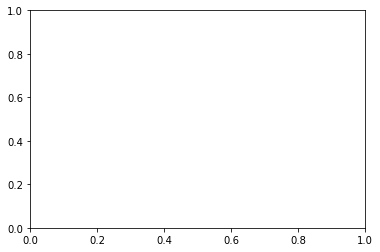

In [13]:
# NUM_PID_SAMPLES = 50
smell_engine = SmellEngine(1000, len(molecules), DataContainer(), debug_mode=True, write_flag=False, PID_mode = False, oms=molecules)  # WRITE MODE ENABLED
# Initialize system
smell_engine.set_odorant_molecule_ids(list(molecules.keys()))
# smell_engine.set_odorant_molecule_dilutions([10, 1, 10])
smell_engine.set_odorant_molecule_dilutions([1])#, 10, 10])
# smell_engine.set_odorant_molecule_dilutions([10,10])
smell_engine.initialize_smell_engine_system()
# smell_engine.olf.logical.num_pid_samples = NUM_PID_SAMPLES
smell_engine.olfactometer.loaded_molecules

# Generate Data
Note this is the cell that takes a long time to execute. 

In [22]:
# Format data for generating Pandas Dataframe
max_flow_rates = smell_engine.smell_controller.get_max_flow_rates()
total_vapor = smell_engine.smell_controller.get_vapor_concs_dense(set(list(smell_engine.target_concentration)))
A = smell_engine.smell_controller.vapor_phase_concentrations.magnitude
n_jars = len(smell_engine.olfactometer.jars)
NUMBER_OF_JARS_WITH_ODORANTS = 1

#alpha = 1e-25

NUMBER_THREADS = 6
threading_results = [1]*NUMBER_THREADS

def generate_optimal_concentration(olfactometer_combinations,index):
    length = len(olfactometer_combinations)
    optimal_concentration_configurations = [(float("inf"),float("inf"))]*len(multi_dim_conc)
    for i in range(length):
        if(i %int(length/1000) == 0): print(f"Thread {index} {(i/length)*1000}") #Progress "bar" old one breaks with threading
        new_conc_combo = list(smell_engine.smell_controller.calc_conc(np.array(olfactometer_combinations[i]), n_jars, max_flow_rates, A).sum(axis=0)[:NUMBER_OF_JARS_WITH_ODORANTS])
        _dist, _index = closest_point(new_conc_combo)
        #Penalty Code based on alpha
        valve_states = np.array(olfactometer_combinations[i][2:])
#         penalty = alpha * np.nan_to_num(np.reciprocal(valve_states),posinf=0, neginf=0).sum() 
        #print(olfactometer_combinations[i][2:],np.nan_to_num(np.reciprocal(valve_states),posinf=0, neginf=0))
        #Penalty Code End 
        if(optimal_concentration_configurations[_index][0]>_dist):
            optimal_concentration_configurations[_index] = (_dist, olfactometer_combinations[i])
    print(f"Thread {index} is ending")
    threading_results[index] = optimal_concentration_configurations


In [23]:
import logging
import threading


#split olfactometer_combinations by number of threads 
olfactometer_combinations_list = []
combination_list_length = len(olfactometer_combinations) / NUMBER_THREADS

for i in range(0,NUMBER_THREADS):
    olfactometer_combinations_list.append(olfactometer_combinations[int(i*combination_list_length):int((i+1)*combination_list_length)])
    
threads = []
for i in range(0,NUMBER_THREADS):
    _thread = threading.Thread(target = generate_optimal_concentration,args = (olfactometer_combinations_list[i],i,))
    threads.append(_thread)
    _thread.start()

Thread 0 0.0
Thread 1 0.0
Thread 2 0.0
Thread 3 0.0Thread 4 0.0

Thread 5 0.0
Thread 1 0.8928571428571428Thread 2 0.8928571428571428
Thread 2 1.7857142857142856
Thread 2 2.6785714285714284
Thread 2 3.571428571428571
Thread 2 4.464285714285714
Thread 2 5.357142857142857
Thread 2 6.25
Thread 2 7.142857142857142
Thread 2 8.035714285714285
Thread 2 8.928571428571429
Thread 2 9.821428571428571
Thread 2 10.714285714285714
Thread 2 11.607142857142858
Thread 2 12.5
Thread 2 13.392857142857142
Thread 2 14.285714285714285
Thread 2 15.178571428571429
Thread 2 16.07142857142857
Thread 2 16.96428571428571
Thread 2 17.857142857142858
Thread 2 18.75
Thread 2 19.642857142857142
Thread 2 20.535714285714285
Thread 2 21.428571428571427
Thread 2 22.321428571428573
Thread 2 23.214285714285715
Thread 2 24.107142857142858
Thread 2 25.0
Thread 2 25.892857142857146
Thread 2 26.785714285714285
Thread 2 27.678571428571427
Thread 2 28.57142857142857
Thread 2 29.464285714285715
Thread 4 0.8928571428571428
Thread 2

In [24]:

final_optimal_concentration_configurations = threading_results[0]


for results in threading_results[1:]:
    for idx, (dist,config) in enumerate(results): 
        if(final_optimal_concentration_configurations[idx][0]>dist):
            final_optimal_concentration_configurations[idx]=(dist,config)
    
optimal_concentration_configurations = final_optimal_concentration_configurations #Works with remaining code


# Format for Data

In [25]:
body_values = []
index_values = []

for idx, machine_config in enumerate(optimal_concentration_configurations):
    if (machine_config[0] != float("inf")):   # Safety check for impossible configs
        index_values.append(tuple(machine_config[1])) # Store machine configuration as index for dataframe
        body_values.append(multi_dim_conc[idx]) # Store concentration as body emtry for dataframe

In [26]:
print(f"There are {len(multi_dim_conc)-len(body_values)} unobtainnable results.")

There are 34 unobtainnable results.


# Wrtie to Data Frame and then Save

In [27]:
# Generate dataframe indexed by oflactometer configurations and body containing concentration values
df = pd.DataFrame(body_values, index=index_values, columns=['Ethanol'])#, 'NA', 'NA', 'NA', 'NA', 'NA', 'NA', 'NA'])

In [28]:
df.to_pickle("./ethanol_test.pkl")

In [ ]:
df.to_csv('./odors_1-1_10-24-21.csv')

# Data Table Validation

In [29]:
import pandas as pd
# Data Table to Read In
df = pd.read_pickle("./ethanol_test.pkl")

In [30]:
state_array = []
for idx, state in enumerate(df.index):
    if(list(state)[-1] != 0):
        print(list(state)[-1])
    conc = [df["Ethanol"][idx]]
    state_array.append(conc + list(state))
# print(*state_array,sep='\n')

In [31]:
df_states = pd.DataFrame(state_array, columns=["cE","mfcA","mfcB","h1","h2","h3","h4","h5","h6","h7","h8","h9","h10","L1","L2","L3","L4","L5","L6","L7","L8","L9","L10"])

In [ ]:
# df_states.loc[(df_states["mfcB"]>0.2) & (df_states["cA"] == 0) & (df_states["dL"] == 0)]
df_states.loc[(df_states["cDL"]>1e-12)  & (df_states["cC"] == 0) & (df_states["cA"] == 0)] #df_states["cE"]== 0)]

In [32]:
pd.set_option("display.max_columns", None)
df_states

,cE,mfcA,mfcB,h1,h2,h3,h4,h5,h6,h7,h8,h9,h10,L1,L2,L3,L4,L5,L6,L7,L8,L9,L10
0,0.000000e+00,0.000000,0.138950,0.01,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.778279e-08,0.000000,0.138950,0.00,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.010000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2.371374e-08,0.000000,0.193070,0.00,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.010000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3.162278e-08,0.000000,0.268270,0.00,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.010000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4.216965e-08,0.000000,0.372759,0.00,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.010000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,5.623413e-08,0.000000,0.517947,0.00,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.010000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,7.498942e-08,0.000000,0.138950,0.00,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.046416,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,1.000000e-07,0.000000,0.193070,0.00,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.046416,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,1.333521e-07,0.000000,0.517947,0.00,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.021544,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,1.778279e-07,0.000000,0.138950,0.00,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.111111,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
